__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Чт 13 июн 2024 12:43:29 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

14209

title  \
2324  участок, 4.16 сот., садоводство   
1202            участок, 10 сот., ижс   
2206             участок, 9 сот., ижс   

                                                                            address  \
2324  севастополь,р-н гагаринский,мкр.фиолент,гранат садоводческое товарищество,130   
1202                                       севастополь,р-н балаклавский,с.оборонное   
2206                               севастополь,р-н нахимовский,улица мореходная,139   

       latitude  longitude  priceM          dt  
2324  44.534334  33.481325    2.70  2024-06-07  
1202  44.517208   33.65257    3.80  2024-06-11  
2206  44.611714  33.562829    2.40  2024-06-07

---

In [4]:
df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

18854

title                                address   latitude  \
2417   Участок 8 сот. (ИЖС)        Севастополь,ул. Лётчика Авдеева  44.673129   
17382  Участок 5 сот. (ИЖС)  Севастополь,ул. Генерала Мельника, 70  44.585515   
3863   Участок 8 сот. (ИЖС)              Севастополь,Лесхозная ул.  44.547652   

       longitude  priceM          dt  
2417   33.552938    2.70  2022-09-13  
17382  33.554349    3.00  2024-06-04  
3863   33.508301    3.65  2022-09-15

In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

18727

title                                 address  \
4409  Участок 2,8 сот. (ИЖС)                Севастополь,Красивая ул.   
119     Участок 7 сот. (ИЖС)            Севастополь,Весенняя ул., 6А   
9068   Участок 10 сот. (ИЖС)  Севастополь,ш. Генерала Моргунова, 119   

       latitude  longitude  priceM          dt                          url  
4409  44.586773  33.473599    7.00  2022-09-15  https://avito.ru/2304417610  
119   44.638825  33.555489    4.50  2022-09-08  https://avito.ru/2404209684  
9068  44.556208  33.561859    7.70  2022-10-08  https://avito.ru/2356773046

In [6]:
# df_['dt'].drop_duplicates()

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

32936

In [9]:
df['month'] = df['ts'].dt.to_period('M')

In [10]:
display( len(df) )
df = df.query('priceM>1e-3').reset_index(drop=True)
display( len(df) )

32936

32879

In [11]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))
df['log_priceMU'] = df['priceMU'].apply(lambda x: np.log(x+1.))

In [12]:
# df[['area','priceM','priceMU']]

---

In [13]:
# df['dt'].drop_duplicates().sort_values()

In [14]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [15]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32879 entries, 0 to 32878
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   url                 32879 non-null  object        
 1   place               32879 non-null  object        
 2   title               32879 non-null  object        
 3   subtitle            5105 non-null   object        
 4   price               32879 non-null  int64         
 5   address             32879 non-null  object        
 6   description         32879 non-null  object        
 7   ts                  32879 non-null  datetime64[ns]
 8   area                32879 non-null  float64       
 9   is_IJS              32879 non-null  bool          
 10  priceM              32879 non-null  float64       
 11  priceMU             32879 non-null  float64       
 12  area_size_category  32825 non-null  category      
 13  address_orig        14186 non-null  object    

In [17]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 


df.loc[ df['address'].str.lower().str.match('бахчисарай.*надежда.*'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('бахчисарай.*с.дачное.*'), ['latitude','longitude'] ] = None 
df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [18]:
df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'


In [19]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

32879

32852

In [20]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [21]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
4436   участок, 130 сот., фермерское хозяйство   
30819                    Участок 10 сот. (ИЖС)   
15571                    Участок 30 сот. (ИЖС)   

                                                                                  address  \
4436                                севастополь,р-н балаклавский,с.терновка,улица садовая   
30819                                              Севастополь,ш. Генерала Моргунова, 125   
15571  Севастополь,Республика Крым, Бахчисарайский район, Песчановское сельское поселение   

       latitude  longitude  priceM          dt  \
4436      44.58      33.74    2.50  2024-06-10   
30819     44.56      33.56    4.10  2023-01-10   
15571     44.88      33.63    1.10  2022-09-12   

                                                       url  
4436   https://sevastopol.cian.ru/sale/suburban/273519742/  
30819                           https://avito.ru/978883016  
15571                          https://avito.ru/2518461426

In [22]:
display( len(df) )
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")').reset_index(drop=True)
display( len(df) )

32852

32852

---

In [23]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 13)

In [24]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [25]:
# display( len(gdf_history) )
display( len(gdf) )

32851

In [26]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [27]:
# gdf['place'].unique()

# общая статистика

In [28]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [29]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [30]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [31]:
# gdf[
#     gdf['address'].str.match(r'бахчисарай.*с.дачное.*')
# ][['title','address','priceM','area_size_category','geometry']]

In [32]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [37]:
gdf.loc[ gdf['priceMU']==np.inf, 'priceMU'] = None
gdf['priceMU'] = gdf['priceMU'].fillna( gdf['priceMU'].max()+1. )

In [38]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
    gdf
    .groupby(['place','month'],observed=True)
    ['priceMU'].describe(percentiles=percentiles)
)

display( stat )

count  mean  std  min   1%   5%  10%  25%  50%  75%  \
place       month                                                            
bahchisaray 2024-06  2514.00  0.15 0.28 0.00 0.00 0.00 0.00 0.01 0.05 0.20   
sevastopol  2022-09  8780.00  0.72 0.71 0.00 0.07 0.19 0.25 0.38 0.55 0.88   
            2022-10  2202.00  0.69 0.61 0.00 0.08 0.18 0.25 0.36 0.55 0.87   
            2022-11  5153.00  0.70 0.96 0.00 0.08 0.18 0.24 0.36 0.52 0.82   
            2023-01   825.00  0.67 0.55 0.00 0.08 0.17 0.24 0.36 0.53 0.83   
            2024-06 12016.00  0.76 1.17 0.00 0.01 0.07 0.16 0.35 0.56 0.83   
sudak       2024-06  1361.00  0.61 0.66 0.00 0.01 0.07 0.13 0.26 0.43 0.73   

                     90%  95%   max  
place       month                    
bahchisaray 2024-06 0.37 0.56  4.67  
sevastopol  2022-09 1.29 1.72 15.00  
            2022-10 1.19 1.57 15.00  
            2022-11 1.15 1.61 16.00  
            2023-01 1.15 1.57  7.50  
            2024-06 1.25 1.75 16.00  
sudak       2024-06 1.09 1.72  5.13

In [40]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
# sizes = stat.reset_index()['area_size_category'].unique()
# sizes = [ '2-4', '4-8', '8-20']
# display( sizes )

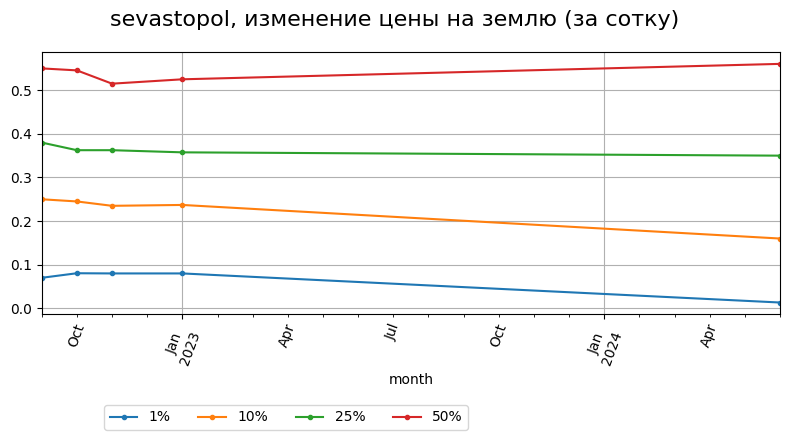

In [41]:
place = 'sevastopol'

fig, ax = plt.subplots(figsize=(8,4) )
stat.loc[(place,),cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [42]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

32851

2821

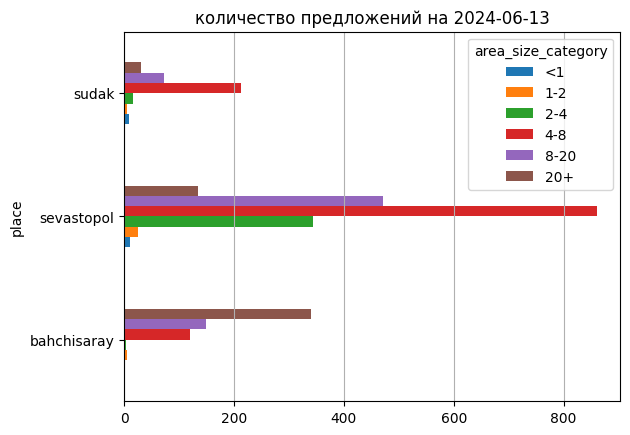

In [43]:
(
gdf_last
.groupby(['area_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [47]:
(
    gdf_last
    .groupby(['place'],observed=False)
    ['priceMU'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%  50%  75%  90%  95%  \
place                                                                         
bahchisaray  620.00  0.15 0.28 0.00 0.00 0.00 0.00 0.01 0.05 0.20 0.35 0.53   
sevastopol  1856.00  0.83 1.39 0.00 0.01 0.11 0.22 0.40 0.59 0.88 1.30 1.80   
sudak        345.00  0.61 0.65 0.00 0.03 0.09 0.14 0.27 0.43 0.73 1.09 1.72   

              max  
place              
bahchisaray  4.67  
sevastopol  16.00  
sudak        5.13

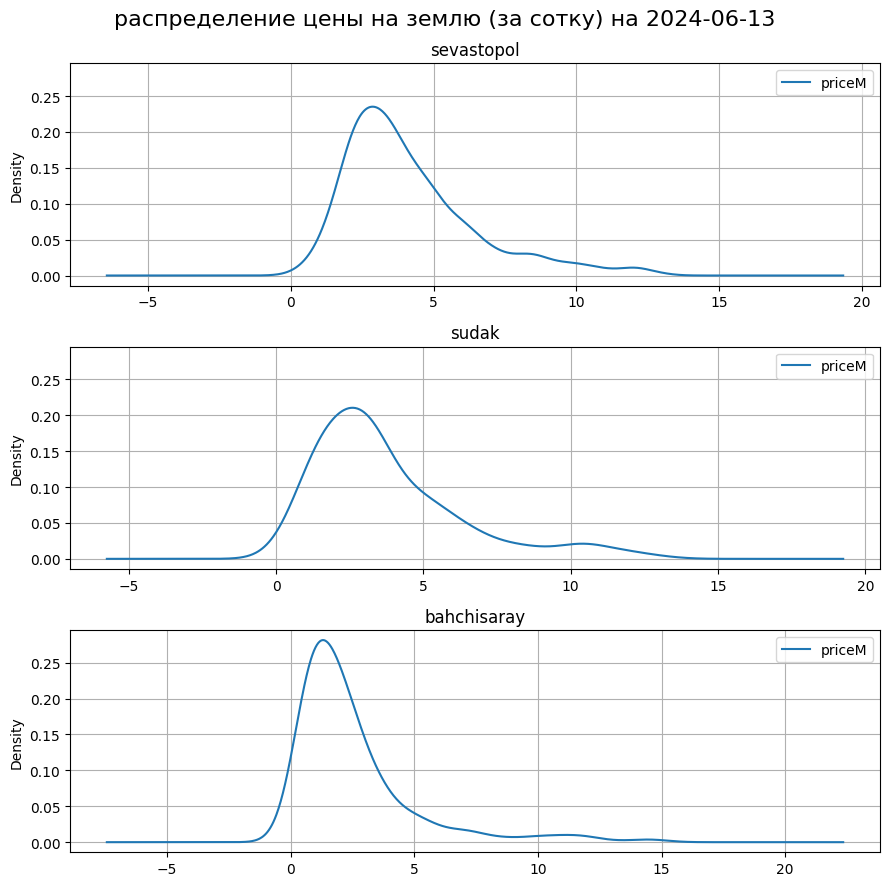

In [49]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        #.groupby(['area_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на землю (за сотку) на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [50]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [51]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [52]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [53]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [54]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [55]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [56]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    [['log_priceMU','priceMU']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceMU','geometry','log_priceMU',]]
    .explore(column='log_priceMU',cmap='rainbow')
)

## Судак

In [57]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [58]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [59]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
   [['log_priceMU','priceMU']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceMU','geometry','log_priceMU',]]
    .explore(column='log_priceMU',cmap='rainbow')
)

# районы Севастополя

In [60]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [61]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [62]:
frames.explore('area_name', legend=True)

In [63]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [69]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

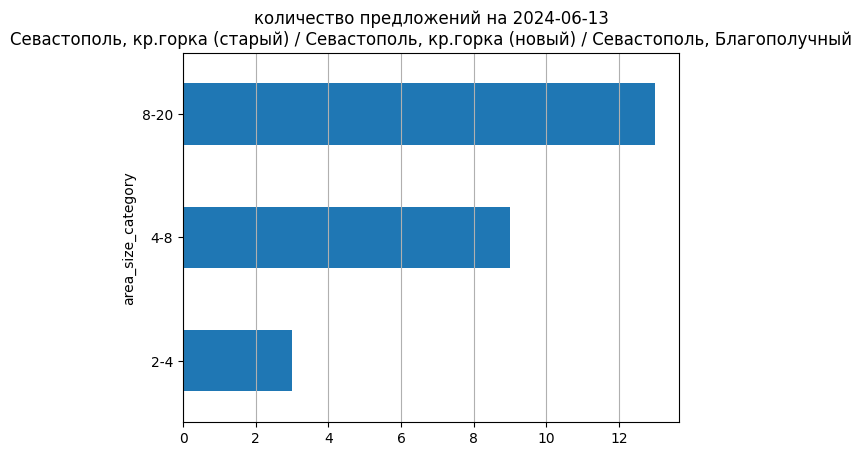

In [70]:
(
    gdf_last_local
    .groupby(['area_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

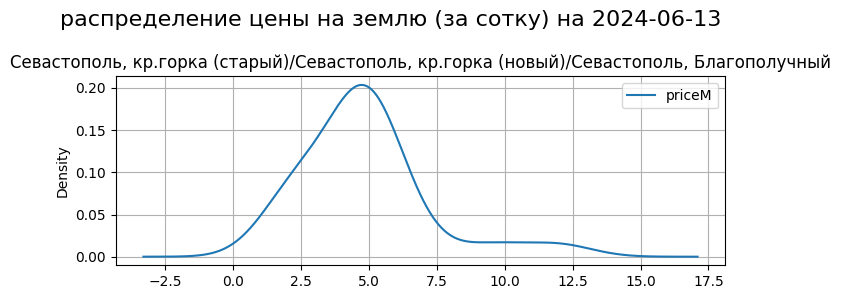

In [72]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на землю (за сотку) на '+ str( gdf_last_local['dt'].max() ), fontsize=16)
fig.tight_layout()

----

In [66]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [67]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = (
    gdf_local
    .groupby(['month'],observed=True)
    ['priceMU'].describe(percentiles=percentiles)
)
display( stat )

count  mean  std  min   1%   5%  10%  25%  50%  75%  90%  max
month                                                                 
2022-09 389.00  0.62 0.27 0.17 0.17 0.34 0.37 0.48 0.56 0.68 0.85 1.78
2022-10  90.00  0.59 0.19 0.16 0.20 0.35 0.40 0.49 0.56 0.67 0.78 1.50
2022-11 219.00  0.58 0.22 0.15 0.20 0.38 0.40 0.47 0.53 0.62 0.85 2.00
2023-01  29.00  0.61 0.26 0.14 0.19 0.33 0.39 0.48 0.53 0.70 0.94 1.37
2024-06 186.00  0.81 0.58 0.09 0.09 0.21 0.41 0.49 0.59 0.90 1.60 3.70

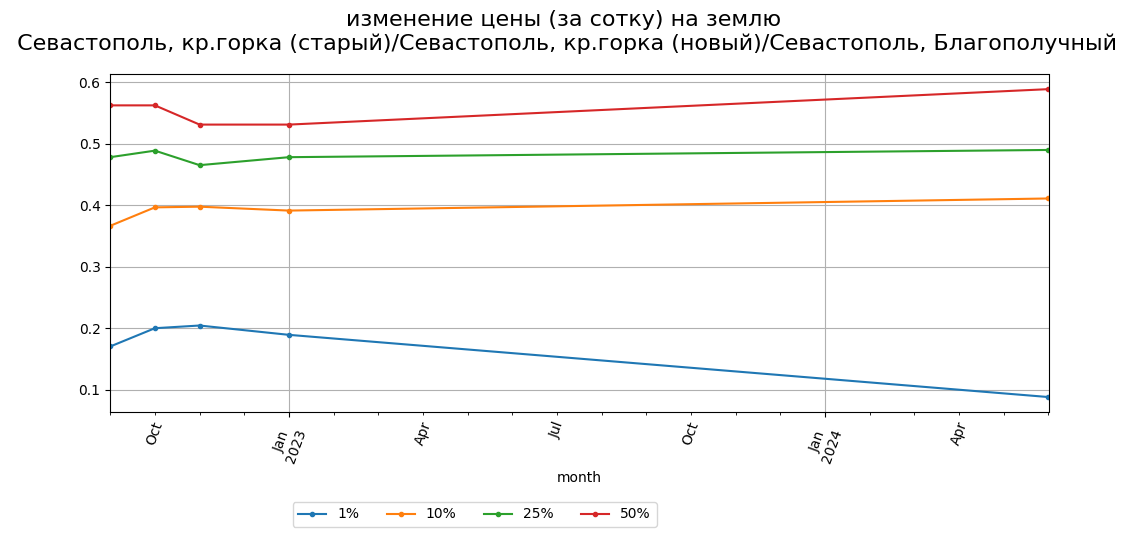

In [68]:
fig, ax = plt.subplots(figsize=(10,5) )

stat[cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены (за сотку) на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()